In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import moyal

In [22]:
import matplotlib.pyplot as plt

plt.style.use(["science", "grid", "notebook"])

plt.rcParams.update(
    {
        "font.size": 16,  # Base font size
        "axes.titlesize": 18,  # Title size
        "axes.labelsize": 16,  # Axis label size
        "xtick.labelsize": 14,  # x tick label size
        "ytick.labelsize": 14,  # y tick label size
        "legend.fontsize": 14,  # Legend font size
    }
)

In [23]:
def get_tdc_spectra(file_path, xlim=None, ylim=None, normalize_y=False, save_pdf=False):
    data = np.loadtxt(file_path, delimiter="\t")
    x, y = data[:, 0], data[:, 1]
    if normalize_y:
        y = y / np.max(y)
        y_label = "Normalized Y-axis"
    else:
        y_label = "TDC counts"

    # Ask for plot title
    title_input = input("Enter the plot title (leave blank for no title): ")

    plt.figure()
    plt.plot(
        x,
        y,
        label="TDC Spectra",
        linestyle=":",
        color="steelblue",
        alpha=1.0,
        linewidth=1,
    )

    plt.xlabel("Channel")
    plt.ylabel(y_label)
    if title_input.strip():
        plt.title(title_input)

    plt.minorticks_on()
    plt.grid(which="both", linestyle="--", linewidth=0.5)

    plt.legend(loc="best", fontsize=9)

    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    plt.tight_layout()
    if save_pdf:
        plt.savefig("TDC_Spectrum.pdf", format="pdf")
    plt.show()
    return x, y

In [24]:
def analyze_tdc_spectrum(
    file_path, xlim=None, ylim=None, normalize_y=False, save_pdf=False
):
    # Load the data
    data = np.loadtxt(file_path, delimiter="\t")
    x, y = data[:, 0], data[:, 1]

    # Normalize y if required
    if normalize_y:
        y = y / np.max(y)
        y_label = "Normalized Y-axis"
    else:
        y_label = "TDC counts"

    # Identify peaks
    from scipy.signal import find_peaks

    peaks, _ = find_peaks(
        y, height=np.max(y) * 0.1
    )  # Adjust height threshold as needed
    peak_positions = x[peaks]
    peak_heights = y[peaks]

    # Sort peaks by channel (ascending) and reverse delays
    sort_idx = np.argsort(peak_positions)
    peak_positions = peak_positions[sort_idx]
    peak_heights = peak_heights[sort_idx]

    # Plot the TDC spectrum with identified peaks
    plt.figure()
    plt.plot(x, y, label="TDC Spectrum", linestyle=":", color="steelblue", linewidth=1)
    plt.scatter(peak_positions, peak_heights, color="red", label="Peaks")
    plt.xlabel("Channel No.")
    plt.ylabel(y_label)
    plt.title("TDC Spectrum with Identified Peaks")
    plt.legend()
    plt.grid(which="both", linestyle="--", linewidth=0.5)
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    plt.tight_layout()
    if save_pdf:
        plt.savefig("TDC_Spectrum_with_Peaks.pdf", format="pdf")
    plt.show()

    # Use reversed time delays
    time_delays = [16, 12, 8, 4, 0]
    if len(peak_positions) != len(time_delays):
        print("Number of peaks found does not match number of time delays!")
        return

    # Linear fit
    from scipy.optimize import curve_fit

    def linear_func(channel, slope, intercept):
        return slope * channel + intercept

    popt, pcov = curve_fit(linear_func, peak_positions, time_delays)
    slope, intercept = popt
    print(f"Linear Fit: Time (ns) = {slope:.4f} * Channel + {intercept:.4f}")

    # Plot channel vs time with linear fit
    plt.figure()
    plt.scatter(peak_positions, time_delays, color="blue", label="Data Points")
    if xlim is not None:
        fit_x = np.linspace(xlim[0], xlim[1], 500)
        plt.xlim(xlim)
    else:
        fit_x = np.linspace(np.min(x), np.max(x), 500)
    plt.plot(
        fit_x,
        linear_func(fit_x, *popt),
        color="red",
        linestyle="--",
        label=f"Linear Fit: Time = {slope:.4f} * Channel + {intercept:.4f}",
    )
    plt.xlabel("Channel No.")
    plt.ylabel("Time (ns)")
    plt.title("Channel vs Time with Linear Fit")
    plt.legend()
    plt.grid(which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    if save_pdf:
        plt.savefig("TDC_Linear_Fit.pdf", format="pdf")
    plt.show()

    return peak_positions, time_delays, slope, intercept

In [25]:
def get_adc_spectra(
    file_path, xlim=None, ylim=None, FWHM=False, normalize_y=False, save_pdf=False
):
    data = np.loadtxt(file_path, delimiter="\t")
    x, y = data[:, 0], data[:, 1]
    if normalize_y:
        y = y / np.max(y)
        y_label = "Normalized Y-axis"
    else:
        y_label = "ADC counts"

    # Ask for plot title
    title_input = input("Enter the plot title (leave blank for no title): ")

    user_input = input(
        "Enter the x range for the fit as 'min,max' (leave blank to skip fit): "
    )
    fit_done = False
    fit_label = "Moyal Fit (on selected range)"
    FWHM_val = None
    fwhm_x1, fwhm_x2, half_max = None, None, None

    if user_input:
        try:
            x_min, x_max = map(float, user_input.split(","))
            mask = (x >= x_min) & (x <= x_max)
            x_fit, y_fit = x[mask], y[mask]

            if len(x_fit) == 0:
                print("No data in the specified range. Skipping fit.")
            else:

                def moyal_func(x, mu, sigma, amplitude):
                    return amplitude * moyal.pdf(x, mu, sigma)

                initial_mu = x_fit[np.argmax(y_fit)]
                initial_sigma = np.std(x_fit) / 2
                initial_amplitude = np.max(
                    y_fit
                )  # Use actual (not normalized) amplitude

                bounds = ([x_fit.min(), 0, 0], [x_fit.max(), np.inf, np.inf])

                popt, pcov = curve_fit(
                    moyal_func,
                    x_fit,
                    y_fit,
                    p0=[initial_mu, initial_sigma, initial_amplitude],
                    bounds=bounds,
                )

                mu, sigma, amplitude = popt

                print("Moyal Fit Parameters:")
                print(f"Mu (Location): {mu}")
                print(f"Sigma (Scale): {sigma}")
                print(f"Amplitude: {amplitude}")

                if FWHM:
                    x_fine = np.linspace(min(x_fit), max(x_fit), 5000)
                    y_fine = moyal_func(x_fine, *popt)
                    half_max = np.max(y_fine) / 2
                    above_half = np.where(y_fine >= half_max)[0]
                    if len(above_half) > 1:
                        fwhm_x1 = x_fine[above_half[0]]
                        r_idx = above_half[-1]
                        if r_idx + 1 < len(x_fine):
                            x_right_l = x_fine[r_idx]
                            x_right_r = x_fine[r_idx + 1]
                            y_right_l = y_fine[r_idx]
                            y_right_r = y_fine[r_idx + 1]
                            fwhm_x2 = x_right_l + (half_max - y_right_l) * (
                                x_right_r - x_right_l
                            ) / (y_right_r - y_right_l)
                        else:
                            fwhm_x2 = x_fine[r_idx]
                        FWHM_val = fwhm_x2 - fwhm_x1
                        print(f"FWHM: {FWHM_val}")
                        print(f"Right FWHM intersection at x = {fwhm_x2:.4f}")
                    else:
                        print("Could not determine FWHM.")

                fit_label = (
                    f"Moyal Fit (on selected range)\n"
                    f"$\\mu$ = {mu:.2f}\n"
                    f"$\\sigma$ = {sigma:.2f}\n"
                    f"Amplitude = {amplitude:.2f}"
                )
                if FWHM and FWHM_val is not None:
                    fit_label += f"\nFWHM = {FWHM_val:.2f}"

                fit_done = True
        except ValueError:
            print("Invalid input. Skipping fit.")

    plt.figure()
    plt.plot(
        x,
        y,
        label="ADC Spectra",
        linestyle=":",
        color="steelblue",
        alpha=1.0,
        linewidth=1,
    )
    if fit_done:
        plt.plot(
            x_fit,
            moyal_func(x_fit, *popt),
            color="red",
            label=fit_label,
            linewidth=1.75,
        )
        if (
            FWHM
            and FWHM_val is not None
            and fwhm_x1 is not None
            and fwhm_x2 is not None
        ):
            plt.hlines(
                half_max,
                fwhm_x1,
                fwhm_x2,
                color="green",
                linestyle="dotted",
                linewidth=2,
                label="FWHM",
            )
            plt.vlines(
                [fwhm_x1, fwhm_x2],
                0,
                half_max,
                color="green",
                linestyle="dotted",
                linewidth=1,
            )
            plt.scatter(fwhm_x2, half_max, color="green", zorder=5)
            plt.annotate(
                f"Edge = {fwhm_x2:.2f}",
                (fwhm_x2, half_max),
                textcoords="offset points",
                xytext=(15, 5),
                ha="left",
                fontsize=14,  # match legend and axis label size
                color="green",
                arrowprops=dict(arrowstyle="->", color="green"),
            )

    plt.xlabel("Channel")
    plt.ylabel(y_label)
    if title_input.strip():
        plt.title(title_input)

    plt.minorticks_on()
    plt.grid(which="both", linestyle="--", linewidth=0.5)

    plt.legend(loc="best", fontsize=9)

    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    plt.tight_layout()
    if save_pdf:
        plt.savefig("ADC_Spectrum.pdf", format="pdf")
    plt.show()
    return x, y

In [26]:
def energy_channel_calibration(
    file_path,
    compton_edge="Na22",
    xlim=None,
    ylim=None,
    normalize_y=False,
    interactive_edge=False,
    save_plots=False,
    save_pdf=False,
):
    """
    Calibrate channel to energy using Compton edge and 0-energy peak.

    Args:
        file_path (str): Path to ADC spectrum file.
        compton_edge (str): "Na22" or "Co60". For Co60, will prompt for which edge.
        xlim (tuple): x-axis limits for spectrum plot.
        ylim (tuple): y-axis limits for spectrum plot.
        normalize_y (bool): Normalize y-axis if True.
        interactive_edge (bool): If True, user clicks to select Compton edge fit range.
        save_plots (bool): Save plots as PNG files.

    Returns:
        slope, intercept: Linear fit parameters (Energy = slope * Channel + intercept)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.optimize import curve_fit
    from scipy.stats import moyal
    from scipy.signal import find_peaks

    # --- Load data ---
    data = np.loadtxt(file_path, delimiter="\t")
    x, y = data[:, 0], data[:, 1]
    if normalize_y:
        y = y / np.max(y)
        y_label = "Normalized ADC counts"
    else:
        y_label = "ADC counts"

    # --- Find 0-energy peak ---
    # Limit search to low x values (first 30% of x-range) for flexibility
    zero_region_mask = x < (np.min(x) + 0.3 * (np.max(x) - np.min(x)))
    x_zero_region = x[zero_region_mask]
    y_zero_region = y[zero_region_mask]

    peaks, properties = find_peaks(y_zero_region, prominence=np.max(y) * 0.05)
    if len(peaks) > 0:
        zero_peak_idx_within_region = peaks[np.argmax(y_zero_region[peaks])]
        zero_peak_idx = np.where(zero_region_mask)[0][zero_peak_idx_within_region]
    else:
        print("Warning: No peak found. Taking maximum in early x-region.")
        zero_peak_idx = np.where(zero_region_mask)[0][np.argmax(y_zero_region)]

    zero_channel = x[zero_peak_idx]

    # --- Select Compton Edge Fit Range ---
    if interactive_edge:
        print("Please click two points to select x-range for Compton edge fitting...")
        fig, ax = plt.subplots()
        ax.plot(x, y, color="steelblue", linestyle=":", linewidth=1)
        ax.set_xlabel("Channel")
        ax.set_ylabel(y_label)
        ax.set_title("Select Compton Edge Fit Range")
        pts = plt.ginput(2, timeout=0)
        plt.close(fig)
        x_min, x_max = sorted([p[0] for p in pts])
    else:
        user_input = input("Enter Compton edge x-range (min,max): ")
        try:
            x_min, x_max = map(float, user_input.split(","))
        except Exception:
            print("Invalid input. Aborting.")
            return

    mask = (x >= x_min) & (x <= x_max)
    x_fit, y_fit = x[mask], y[mask]

    # --- Moyal Fit for Compton Edge ---
    def moyal_func(x, mu, sigma, amplitude):
        return amplitude * moyal.pdf(x, mu, sigma)

    p0 = [x_fit[np.argmax(y_fit)], np.std(x_fit) / 2, np.max(y_fit)]
    bounds = ([x_fit.min(), 0, 0], [x_fit.max(), np.inf, np.inf])

    popt, _ = curve_fit(moyal_func, x_fit, y_fit, p0=p0, bounds=bounds)
    mu, sigma, amplitude = popt

    # --- Determine Compton Edge Channel ---
    x_fine = np.linspace(x_fit.min(), x_fit.max(), 5000)
    y_fine = moyal_func(x_fine, *popt)
    half_max = np.max(y_fine) / 2
    above_half = np.where(y_fine >= half_max)[0]

    if len(above_half) > 1:
        fwhm_x1 = x_fine[above_half[0]]
        fwhm_x2 = x_fine[above_half[-1]]  # Compton edge
    else:
        print("Could not find Compton edge properly.")
        return

    # --- Assign Energy Values ---
    if compton_edge == "Na22":
        edge_energy = 0.341  # MeV
    elif compton_edge == "Co60":
        print("Co60 has two Compton edges: 0.963 MeV and 1.118 MeV.")
        edge_energy = float(
            input("Enter which Compton edge energy to use (0.963 or 1.118): ")
        )
    else:
        print("Unknown Compton edge input.")
        return

    # --- Linear Calibration Fit ---
    channels = np.array([zero_channel, fwhm_x2])
    energies = np.array([0, edge_energy])

    def linear_func(channel, slope, intercept):
        return slope * channel + intercept

    popt2, _ = curve_fit(linear_func, channels, energies)
    slope, intercept = popt2

    print(f"Calibration: Energy (MeV) = {slope:.6f} * Channel + {intercept:.6f}")

    # --- Plot: ADC Spectrum ---
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(x, y, label="ADC Spectra", linestyle=":", color="steelblue", linewidth=1)
    ax.plot(
        x_fit, moyal_func(x_fit, *popt), color="red", label="Moyal Fit", linewidth=1.75
    )
    ax.hlines(
        half_max,
        fwhm_x1,
        fwhm_x2,
        color="green",
        linestyle="dotted",
        linewidth=2,
        label="FWHM",
    )
    ax.vlines(
        [fwhm_x1, fwhm_x2], 0, half_max, color="green", linestyle="dotted", linewidth=1
    )
    ax.scatter(fwhm_x2, half_max, color="green", zorder=5)
    ax.scatter(
        zero_channel,
        y[int(zero_peak_idx)],
        color="purple",
        label="0-energy peak",
        zorder=10,
    )

    # Expand ylim to fit annotations
    y_max = np.max(y)
    ax.set_ylim(0, y_max * 1.2)

    # Annotate 0-energy peak (shift below peak)
    ax.annotate(
        f"0-energy\npeak = {zero_channel:.2f}",
        (zero_channel, y[int(zero_peak_idx)]),
        textcoords="offset points",
        xytext=(15, -30),
        ha="left",
        fontsize=14,  # match legend and axis label size
        color="purple",
        arrowprops=dict(arrowstyle="->", color="purple"),
    )

    # Annotate Compton Edge
    ax.annotate(
        f"Edge = {fwhm_x2:.2f}",
        (fwhm_x2, half_max),
        textcoords="offset points",
        xytext=(15, 5),
        ha="left",
        fontsize=14,  # match legend and axis label size
        color="green",
        arrowprops=dict(arrowstyle="->", color="green"),
    )

    ax.set_xlabel("Channel", fontsize=16)
    ax.set_ylabel(y_label, fontsize=16)
    ax.set_title("ADC Spectrum with Compton Edge and 0-energy Peak", fontsize=18)
    ax.grid(which="both", linestyle="--", linewidth=0.5)
    ax.legend(fontsize=14)
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    plt.tight_layout()

    if save_plots:
        plt.savefig("ADC_Spectrum_Calibration.png", dpi=300)
    if save_pdf:
        plt.savefig("ADC_Spectrum_Calibration.pdf", format="pdf")
    plt.show()

    # --- Plot: Channel vs Energy Calibration ---
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.scatter(channels, energies, color="blue", label="Calibration Points")
    fit_x = np.linspace(np.min(channels), np.max(channels), 100)
    ax.plot(
        fit_x,
        linear_func(fit_x, *popt2),
        "r--",
        label=f"E = {slope:.4f} × Ch + {intercept:.4f}",
    )
    ax.set_xlabel("Channel")
    ax.set_ylabel("Energy (MeV)")
    ax.set_title("Channel-Energy Calibration")
    ax.grid(which="both", linestyle="--", linewidth=0.5)
    ax.legend()
    plt.tight_layout()

    if save_plots:
        plt.savefig("Calibration_Line.png", dpi=300)
    if save_pdf:
        plt.savefig("Calibration_Line.pdf", format="pdf")
    plt.show()

    return slope, intercept

Moyal Fit Parameters:
Mu (Location): 286.27073344304125
Sigma (Scale): 21.286330391772985
Amplitude: 7803.62416465307
FWHM: 76.4069384965826
Right FWHM intersection at x = 334.8986


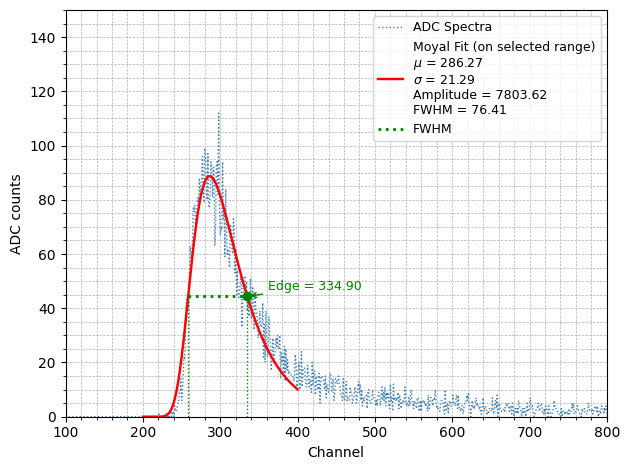

(array([1.000e+00, 2.000e+00, 3.000e+00, ..., 1.137e+03, 1.138e+03,
        1.139e+03]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [140]:
get_adc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.3/light-on/free_spectra_lightON_chA_adc_a.txt",
    xlim=(100, 800),
    ylim=(0, 150),
    FWHM=True,
)

Moyal Fit Parameters:
Mu (Location): 288.2842736153144
Sigma (Scale): 22.590516989231542
Amplitude: 7654.24373547823
FWHM: 81.07978815033835
Right FWHM intersection at x = 339.8916


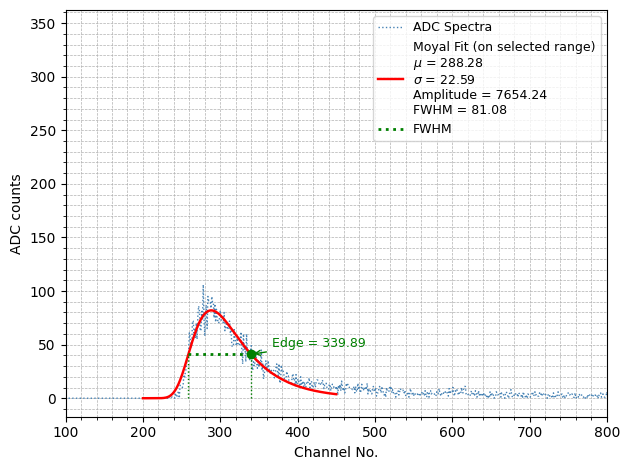

(array([1.000e+00, 2.000e+00, 3.000e+00, ..., 1.137e+03, 1.138e+03,
        1.139e+03]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [108]:
get_adc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.3/light-off/free_spectra_lightOFF_chA_adc_a.txt",
    xlim=(100, 800),
    # ylim=(0, 0.45),
    FWHM=True,
    normalize_y=False,
)

## Section 5.1.4


### Time Calibration


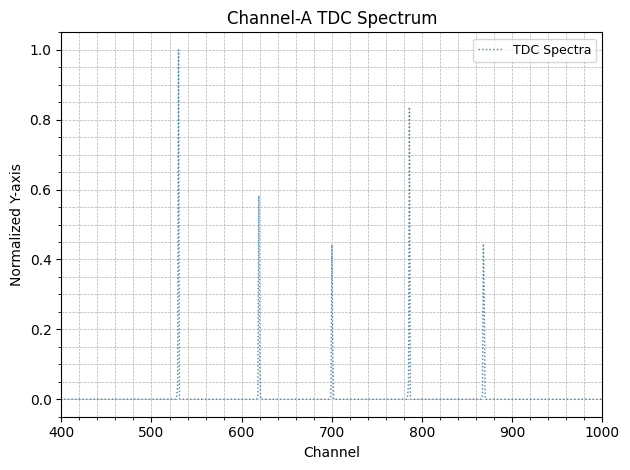

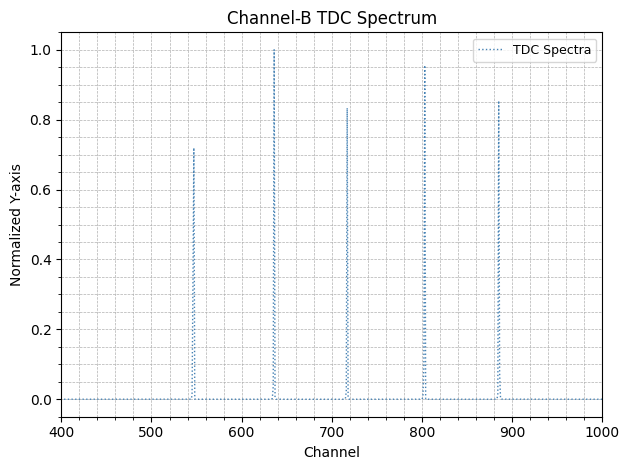

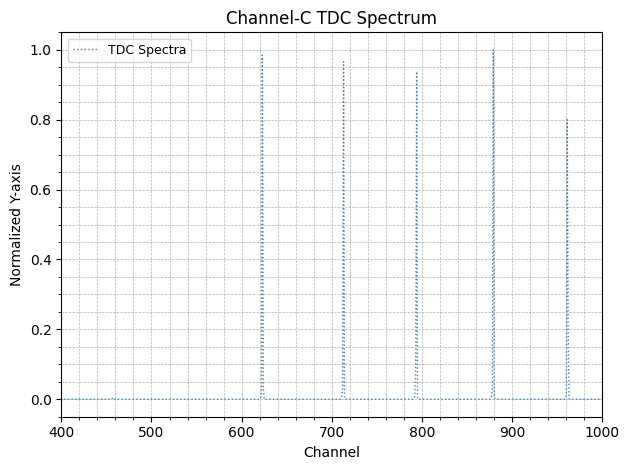

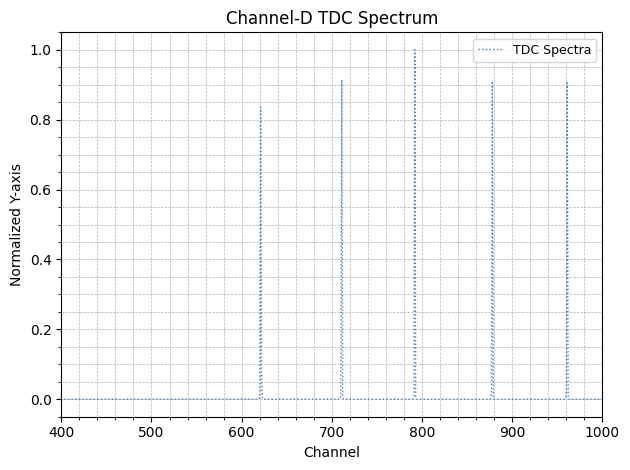

(array([1.000e+00, 2.000e+00, 3.000e+00, ..., 4.093e+03, 4.094e+03,
        4.095e+03]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [126]:
get_tdc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/time calib/co60_time_calib_chA_tdc_a.txt",
    xlim=(400, 1000),
    normalize_y=True,
)
get_tdc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/time calib/co60_time_calib_chB_tdc_b.txt",
    xlim=(400, 1000),
    normalize_y=True,
)
get_tdc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/time calib/co60_time_calib_chC_tdc_c.txt",
    xlim=(400, 1000),
    normalize_y=True,
)
get_tdc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/time calib/co60_time_calib_chD_tdc_d.txt",
    xlim=(400, 1000),
    normalize_y=True,
)

In [ ]:
def analyze_tdc_spectrum(
    file_path, xlim=None, ylim=None, normalize_y=False, save_pdf=False
):
    # Load the data
    data = np.loadtxt(file_path, delimiter="\t")
    x, y = data[:, 0], data[:, 1]

    # Normalize y if required
    if normalize_y:
        y = y / np.max(y)
        y_label = "Normalized Y-axis"
    else:
        y_label = "TDC counts"

    # Identify peaks
    from scipy.signal import find_peaks

    peaks, _ = find_peaks(
        y, height=np.max(y) * 0.1
    )  # Adjust height threshold as needed
    peak_positions = x[peaks]
    peak_heights = y[peaks]

    # Sort peaks by channel (ascending) and reverse delays
    sort_idx = np.argsort(peak_positions)
    peak_positions = peak_positions[sort_idx]
    peak_heights = peak_heights[sort_idx]

    # Plot the TDC spectrum with identified peaks
    plt.figure()
    plt.plot(x, y, label="TDC Spectrum", linestyle=":", color="steelblue", linewidth=1)
    plt.scatter(peak_positions, peak_heights, color="red", label="Peaks")
    plt.xlabel("Channel No.")
    plt.ylabel(y_label)
    plt.title("TDC Spectrum with Identified Peaks")
    plt.legend()
    plt.grid(which="both", linestyle="--", linewidth=0.5)
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    plt.tight_layout()
    if save_pdf:
        plt.savefig("TDC_Spectrum_with_Peaks.pdf", format="pdf")
    plt.show()

    # Use reversed time delays
    time_delays = [16, 12, 8, 4, 0]
    if len(peak_positions) != len(time_delays):
        print("Number of peaks found does not match number of time delays!")
        return

    # Linear fit
    from scipy.optimize import curve_fit

    def linear_func(channel, slope, intercept):
        return slope * channel + intercept

    popt, pcov = curve_fit(linear_func, peak_positions, time_delays)
    slope, intercept = popt
    print(f"Linear Fit: Time (ns) = {slope:.4f} * Channel + {intercept:.4f}")

    # Plot channel vs time with linear fit
    plt.figure()
    plt.scatter(peak_positions, time_delays, color="blue", label="Data Points")
    if xlim is not None:
        fit_x = np.linspace(xlim[0], xlim[1], 500)
        plt.xlim(xlim)
    else:
        fit_x = np.linspace(np.min(x), np.max(x), 500)
    plt.plot(
        fit_x,
        linear_func(fit_x, *popt),
        color="red",
        linestyle="--",
        label=f"Linear Fit: Time = {slope:.4f} * Channel + {intercept:.4f}",
    )
    plt.xlabel("Channel No.")
    plt.ylabel("Time (ns)")
    plt.title("Channel vs Time with Linear Fit")
    plt.legend()
    plt.grid(which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    if save_pdf:
        plt.savefig("TDC_Linear_Fit.pdf", format="pdf")
    plt.show()

    return peak_positions, time_delays, slope, intercept

#### Channel-A PMT-A


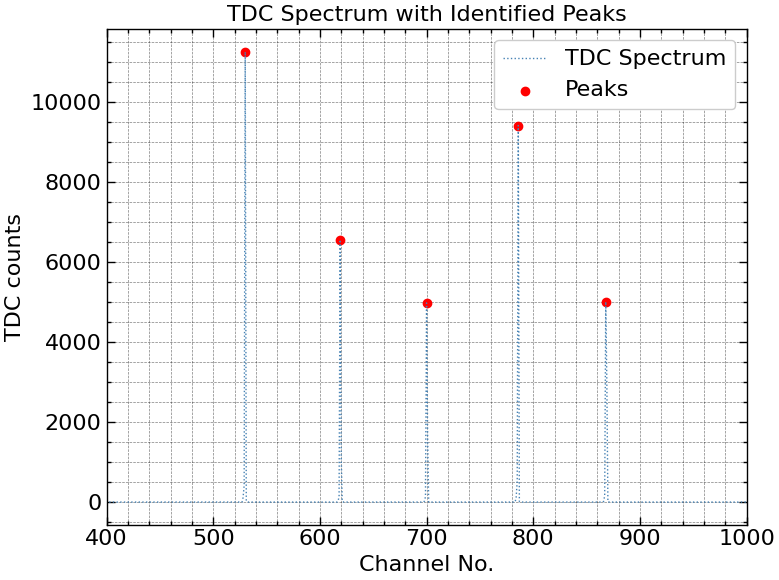

Linear Fit: Time (ns) = -0.0474 * Channel + 41.2365


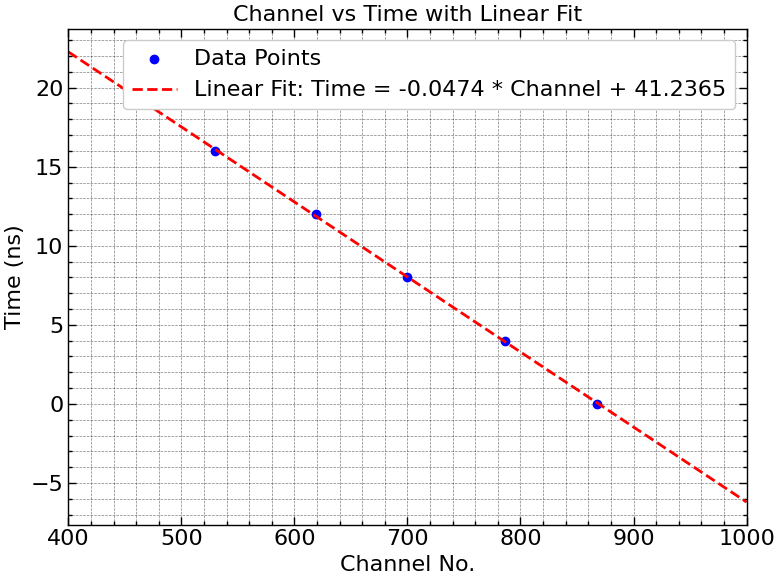

(array([530., 619., 700., 786., 868.]),
 [16, 12, 8, 4, 0],
 -0.04744003871492179,
 41.236491123674206)

In [13]:
analyze_tdc_spectrum(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/time calib/co60_time_calib_chA_tdc_a.txt",
    xlim=(400, 1000),
)

#### Channel-B PMT-B


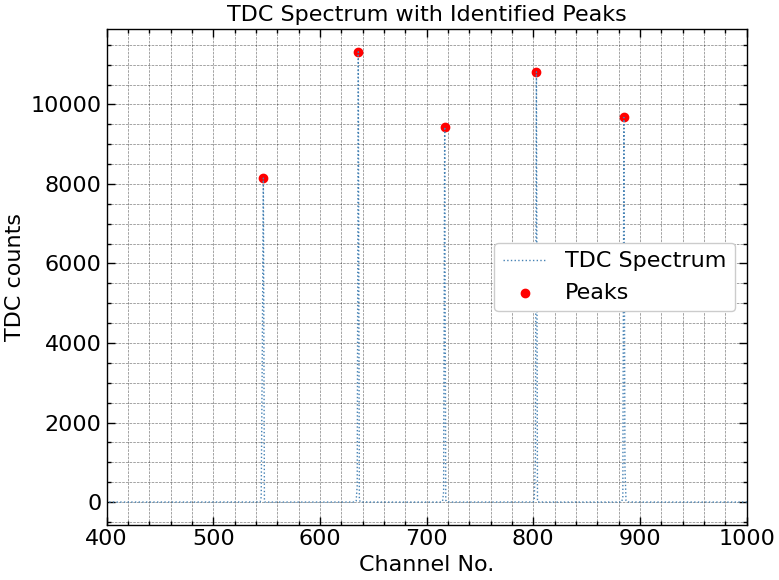

Linear Fit: Time (ns) = -0.0474 * Channel + 42.0430


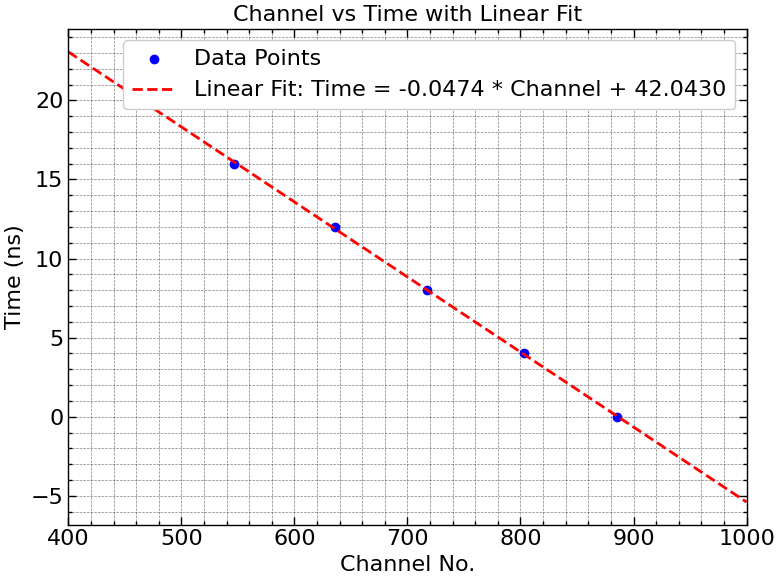

(array([547., 636., 717., 803., 885.]),
 [16, 12, 8, 4, 0],
 -0.04744003871965852,
 42.042971783677125)

In [14]:
analyze_tdc_spectrum(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/time calib/co60_time_calib_chB_tdc_b.txt",
    xlim=(400, 1000),
)

#### Channel-C PMT-C


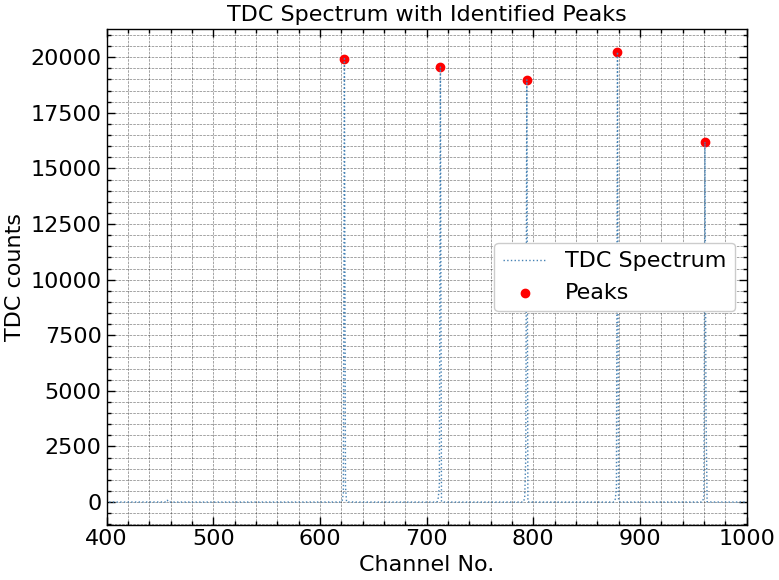

Linear Fit: Time (ns) = -0.0475 * Channel + 45.7093


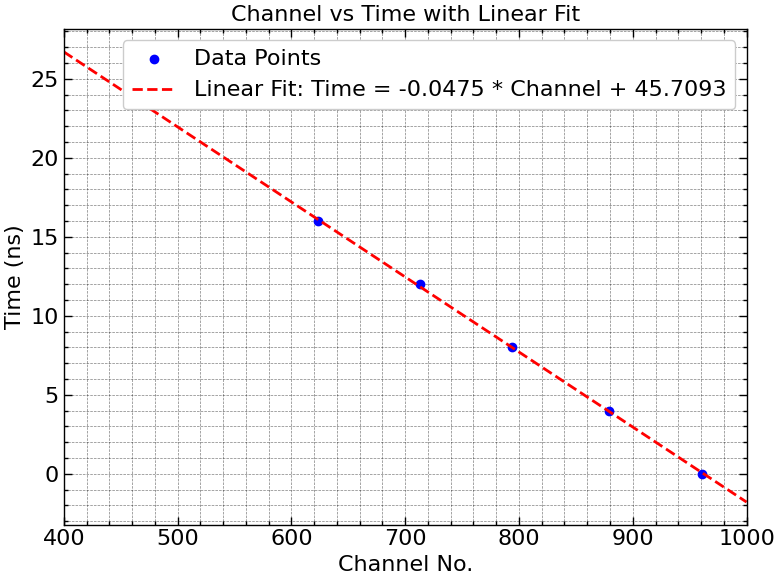

(array([623., 713., 794., 879., 961.]),
 [16, 12, 8, 4, 0],
 -0.04749280839421825,
 45.709289865009296)

In [15]:
analyze_tdc_spectrum(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/time calib/co60_time_calib_chC_tdc_c.txt",
    xlim=(400, 1000),
)

#### Channel-D PMT-D


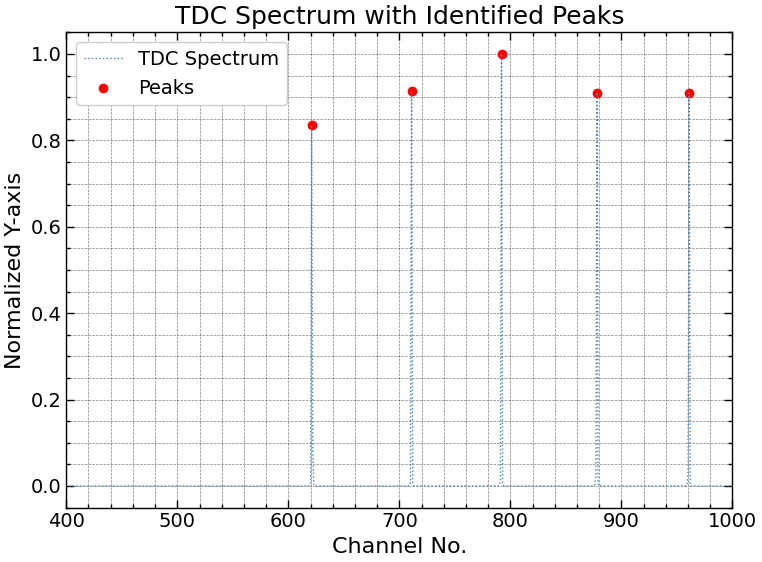

Linear Fit: Time (ns) = -0.0472 * Channel + 45.4224


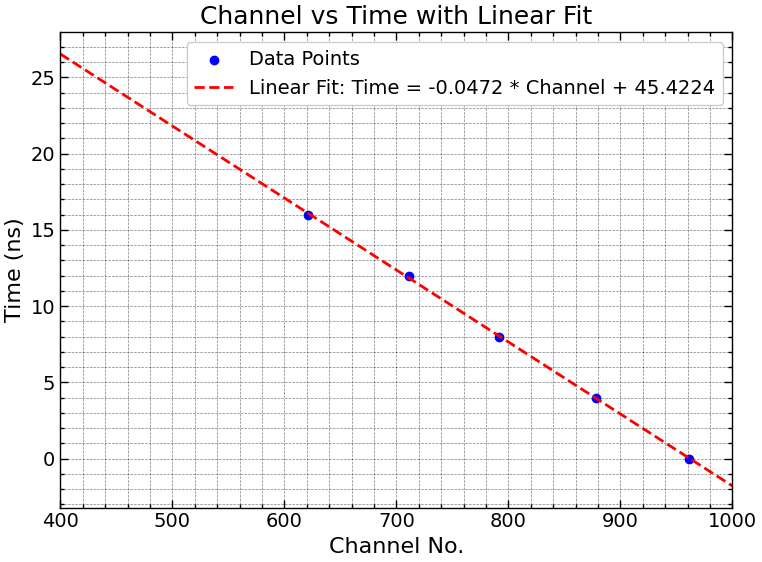

(array([621., 711., 792., 878., 961.]),
 [16, 12, 8, 4, 0],
 -0.04721477426883891,
 45.4224300837682)

In [ ]:
analyze_tdc_spectrum(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/time calib/co60_time_calib_chD_tdc_d.txt",
    xlim=(400, 1000),
    normalize_y=True,
    additional_param=True,
)

#### Time calibration linear fit functions of Channel A,B,C,D respectively:

A- Linear Fit: Time (ns) = -0.0474 _ Channel + 41.2365  
B- Linear Fit: Time (ns) = -0.0474 _ Channel + 42.0430  
C- Linear Fit: Time (ns) = -0.0475 _ Channel + 45.7093  
D- Linear Fit: Time (ns) = -0.0472 _ Channel + 45.4224


### Energy Calibration


Co60 has two Compton edges: 0.963 MeV and 1.118 MeV.
Calibration: Energy (MeV) = 0.007357 * Channel + -1.338904
Calibration: Energy (MeV) = 0.007357 * Channel + -1.338904


/var/folders/wj/k99vprr92qldz634zv4211ch0000gn/T/ipykernel_45493/906680530.py:120: OptimizeWarning: Covariance of the parameters could not be estimated
  popt2, _ = curve_fit(linear_func, channels, energies)


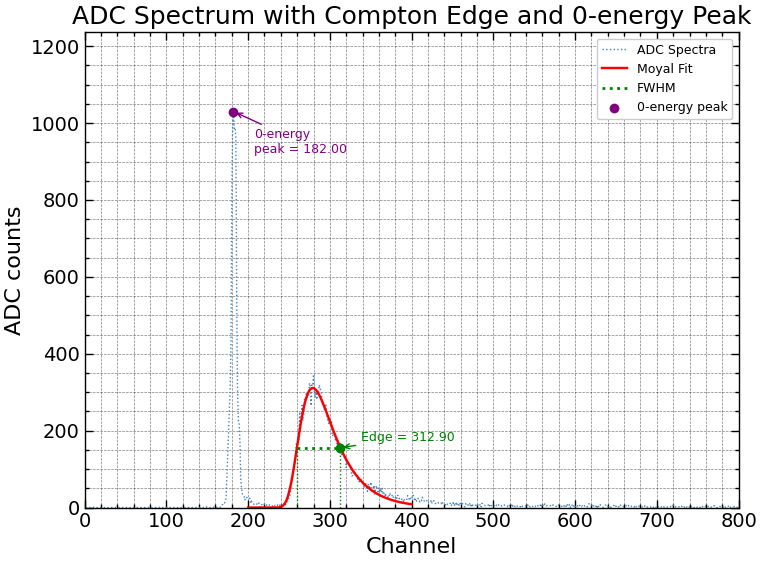

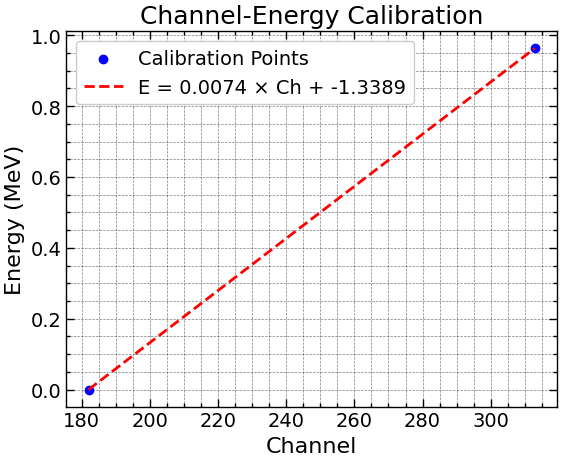

(0.00735661586046071, -1.3389040866038493)

In [21]:
energy_channel_calibration(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/energy calib/energy_calib_Co60_chA_adc_a.txt",
    compton_edge="Co60",
    xlim=(0, 800),
)